In [22]:
from collections import Counter
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [23]:
# LOAD DATA
coup = pd.read_csv("Coup_Data_v2.0.0.csv")
coup['country'] = np.where(coup.country == 'Ecudaor', 'Ecuador',
                           np.where(coup.country == 'Surinam', 'Suriname', coup.country))
#coup = coup[coup.country != 'Sudan']
coup.reset_index(inplace=True)

# SPLIT PREDICTORS AND RESPONSE VARIABLE
x = coup[['military',
       'dissident', 'rebel', 'palace', 'foreign', 'auto', 'resign', 'popular',
       'counter', 'other']]
y = coup.realized

In [24]:
# Perform train-validation split as required 
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=1
)

In [25]:
len(x_train.columns)

10

# Find Best Alpha

In [26]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

alpha_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
max_degree = 2

include_bias = False
fit_intercept = True

# Increase our LASSO max_iters as described in our written
max_iter = 1000
x_train_scale = (x_train - x_train.mean())/x_train.std()
x_poly_train = PolynomialFeatures(
    max_degree, include_bias=include_bias
).fit_transform(x_train_scale)
lasso = LassoCV(alphas=alpha_list, cv=10, fit_intercept=fit_intercept, max_iter=max_iter)
lasso.fit(x_poly_train, y_train);
lassoCV_val_mses_mean = lasso.mse_path_.mean(axis=1)
lassoCV_val_mses_std = lasso.mse_path_.std(axis=1)
best_alpha = lasso.alpha_


In [27]:
import eli5
from eli5.sklearn import PermutationImportance

In [28]:
perm = PermutationImportance(lasso, random_state=1, n_iter=100).fit(x_test, y_test)
eli5.show_weights(perm, feature_names=x.columns.tolist())

C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


ValueError: X has 10 features, but LassoCV is expecting 65 features as input.

In [184]:
#PolynomialFeatures(
#    max_degree, include_bias=include_bias
#)
p = PolynomialFeatures(
    max_degree, include_bias=include_bias
).fit(x_train_scale)
polycols = p.get_feature_names(x_train.columns)

C:\Your\Root\Prefix\envs\cs109a\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


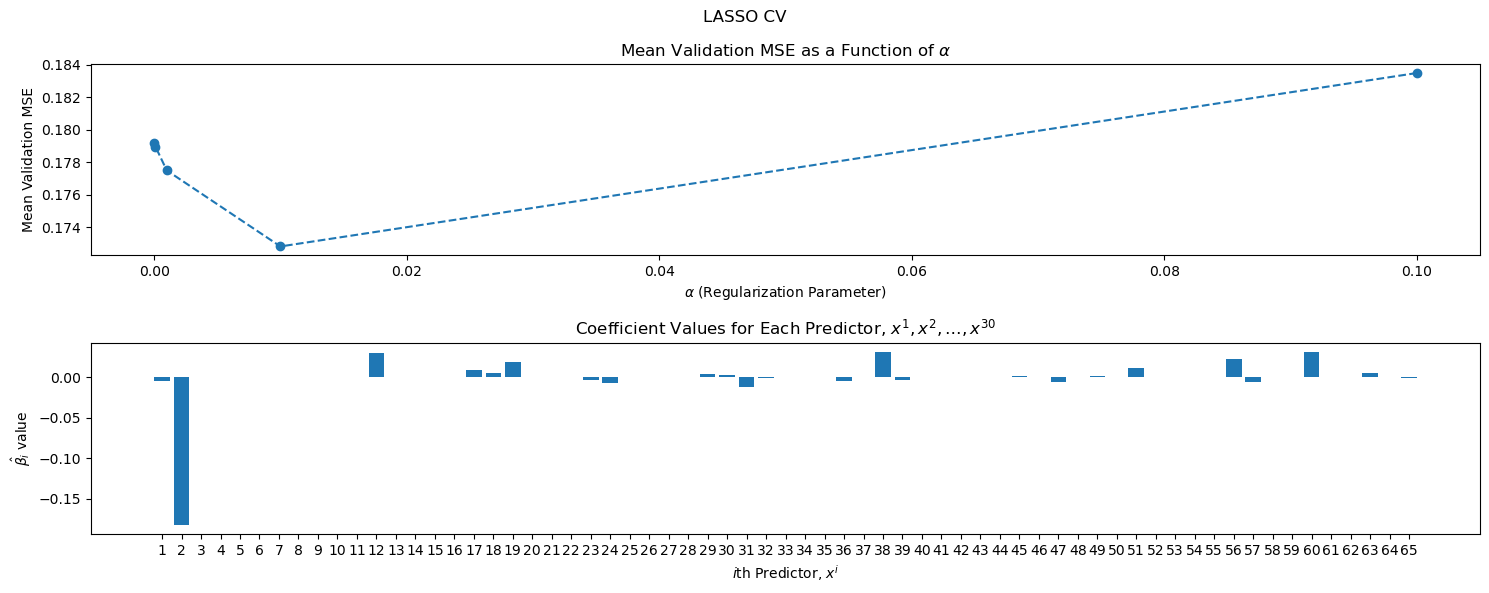

In [185]:
fig, axes = plt.subplots(2,1, figsize=(15,6))
axes[0].plot(lasso.alphas_, lassoCV_val_mses_mean, 'o--')
axes[0].set(
    xlabel=r'$\alpha$ (Regularization Parameter)',
    ylabel='Mean Validation MSE',
    title=r'Mean Validation MSE as a Function of $\alpha$',
)
axes[1].bar(range(1,len(lasso.coef_)+1), lasso.coef_)
axes[1].set(
    title=r"Coefficient Values for Each Predictor, $x^1, x^2, \dots, x^{30}$",
    xlabel=r'$i$th Predictor, $x^i$',
    ylabel=r'$\hat{\beta_i}}$ value',
    xticks=(range(1,len(lasso.coef_)+1)),
)
plt.suptitle("LASSO CV")
plt.tight_layout();

In [186]:
coefs = lasso.coef_
coefs2 = coefs != 0
coefs2
sig_features = []
for i in range(len(polycols)):
    if coefs2[i] == True:
        sig_features.append(polycols[i])

In [187]:
sig_features

['military',
 'dissident',
 'military dissident',
 'military foreign',
 'military resign',
 'military popular',
 'military counter',
 'dissident palace',
 'dissident foreign',
 'dissident other',
 'rebel^2',
 'rebel palace',
 'rebel foreign',
 'rebel counter',
 'palace^2',
 'palace foreign',
 'foreign^2',
 'foreign resign',
 'foreign counter',
 'auto^2',
 'resign^2',
 'resign popular',
 'popular^2',
 'counter^2',
 'other^2']

# Find Significant Degrees

In [140]:
# Set bootstrapping parameters
numboot = 100

# Create empty dictionary for storing results
significant_degrees = {}

# Perform bootstraps
df_train =  pd.read_csv("Coup_Data_v2.0.0.csv")
df_tain = df_train[df_train.country != 'Sudan']
for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[['military',
       'dissident', 'rebel', 'palace', 'foreign', 'auto', 'resign', 'popular',
       'counter', 'other']]
    x_poly_train = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.realized

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=max_iter,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

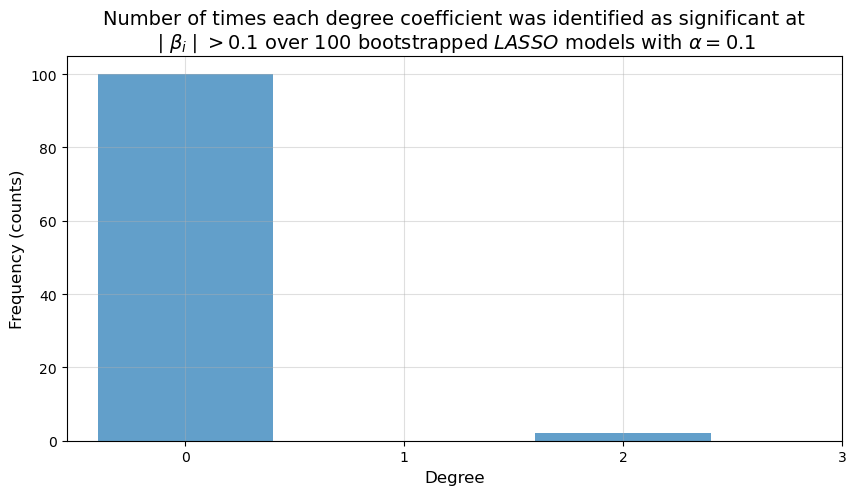

In [141]:
fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

# Use Best Degree and Best Alpha to Fit Lasso

In [142]:
# BEGIN SOLUTION NO PROMPT
best_deg = 2

#Compute the polynomial features for best degree
x_poly_train = PolynomialFeatures(
    best_deg, include_bias=include_bias
).fit_transform(x_train)
x_poly_test = PolynomialFeatures(
    best_deg, include_bias=include_bias
).fit_transform(x_test)

# Fit a linear regression model
lasso = Lasso(
    max_iter=max_iter,
    alpha = best_alpha,
    fit_intercept=fit_intercept,
)
lasso.fit(x_poly_train, y_train)

# Generate predictions
y_train_pred = lasso.predict(x_poly_train)
y_test_pred = lasso.predict(x_poly_test)

mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)

(0.2379178308752231, 0.23346167665985773)